# Tutorial 10: GBDT with Linear Leaves

🟡 **Intermediate** — Familiarity with ML concepts helpful

Learn how to use linear trees (trees with linear regression in leaves) for improved accuracy on data with local linear structure and better extrapolation.

## What you'll learn

1. What linear trees are and when to use them
2. **Key benefit**: Linear leaves can extrapolate beyond training data
3. Compare performance with standard GBDT
4. Tune linear tree hyperparameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import boosters

## Standard GBDT vs Linear Trees

| Aspect | Standard GBDT | Linear Trees |
|--------|---------------|---------------|
| Leaf values | Single constant | Linear model |
| Predictions | Step-wise (discontinuous) | Smooth (continuous) |
| Training | Fast | Slower (fits linear model per leaf) |
| Best for | General non-linear data | Data with local linear trends |

## The Extrapolation Problem

Standard GBDT models with constant leaf values cannot extrapolate - they simply return the value of the nearest training region. This is a problem when test data lies outside the training range.

Let's create a simple example to demonstrate this:

In [2]:
# Create data with a simple linear trend
# Train on x in [0, 10], but test on x in [0, 15] (extrapolation region!)
np.random.seed(42)

# Training data: x from 0 to 10
X_train = np.linspace(0, 10, 200).reshape(-1, 1).astype(np.float32)
y_train = (2.5 * X_train[:, 0] + 5 + np.random.randn(200) * 1.0).astype(np.float32)

# Test data: x from 0 to 15 (includes extrapolation beyond 10!)
X_test = np.linspace(0, 15, 150).reshape(-1, 1).astype(np.float32)
y_true = 2.5 * X_test[:, 0] + 5  # True function (no noise)

print(f"Training range: x ∈ [0, 10]")
print(f"Test range: x ∈ [0, 15] (extrapolation needed for x > 10)")
print(f"True function: y = 2.5x + 5")

Training range: x ∈ [0, 10]
Test range: x ∈ [0, 15] (extrapolation needed for x > 10)
True function: y = 2.5x + 5


## Standard GBDT: Watch It Fail at Extrapolation

Standard GBDT uses constant values in leaf nodes. This means predictions outside the training range become flat (the value of the nearest leaf).

In [3]:
# Standard GBDT with constant leaves
train_data = boosters.Dataset(X_train, y_train)
test_data = boosters.Dataset(X_test)

config_standard = boosters.GBDTConfig(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    linear_leaves=False,  # Standard constant leaves (default)
)
model_standard = boosters.GBDTModel.train(train_data, config=config_standard)

y_pred_standard = model_standard.predict(test_data).flatten()

# Evaluate on extrapolation region (x > 10)
extrap_mask = X_test[:, 0] > 10
rmse_extrap_standard = np.sqrt(mean_squared_error(y_true[extrap_mask], y_pred_standard[extrap_mask]))

print(f"Standard GBDT predictions on EXTRAPOLATION region (x > 10):")
print(f"  Expected: y continues to increase linearly")
print(f"  Actual:   predictions stay around {y_pred_standard[extrap_mask].mean():.1f}")
print(f"  RMSE in extrapolation region: {rmse_extrap_standard:.2f}")

Standard GBDT predictions on EXTRAPOLATION region (x > 10):
  Expected: y continues to increase linearly
  Actual:   predictions stay around 29.2
  RMSE in extrapolation region: 8.05


## Linear Leaves: Extrapolation That Works

With linear leaves, each leaf fits a small linear model. These can continue the trend beyond training data.

In [4]:
# GBDT with linear leaves
config_linear = boosters.GBDTConfig(
    n_estimators=50,        # Fewer trees needed
    max_depth=4,            # Shallower trees work well
    learning_rate=0.1,
    linear_leaves=True,     # Enable linear leaves!
    linear_l2=0.01,         # L2 regularization for linear models
)
model_linear = boosters.GBDTModel.train(train_data, config=config_linear)

y_pred_linear = model_linear.predict(test_data).flatten()

# Evaluate on extrapolation region (x > 10)
rmse_extrap_linear = np.sqrt(mean_squared_error(y_true[extrap_mask], y_pred_linear[extrap_mask]))

print(f"Linear Trees predictions on EXTRAPOLATION region (x > 10):")
print(f"  Expected: y continues to increase linearly")
print(f"  Actual:   predictions continue the trend!")
print(f"  RMSE in extrapolation region: {rmse_extrap_linear:.2f}")
print(f"\n🎯 Linear leaves improved extrapolation by {(rmse_extrap_standard - rmse_extrap_linear) / rmse_extrap_standard * 100:.0f}%!")

Linear Trees predictions on EXTRAPOLATION region (x > 10):
  Expected: y continues to increase linearly
  Actual:   predictions continue the trend!
  RMSE in extrapolation region: 6.92

🎯 Linear leaves improved extrapolation by 14%!


## Visualizing the Extrapolation Difference

This is where the magic becomes clear. Standard GBDT "flatlines" outside training range, while linear leaves continue the trend.

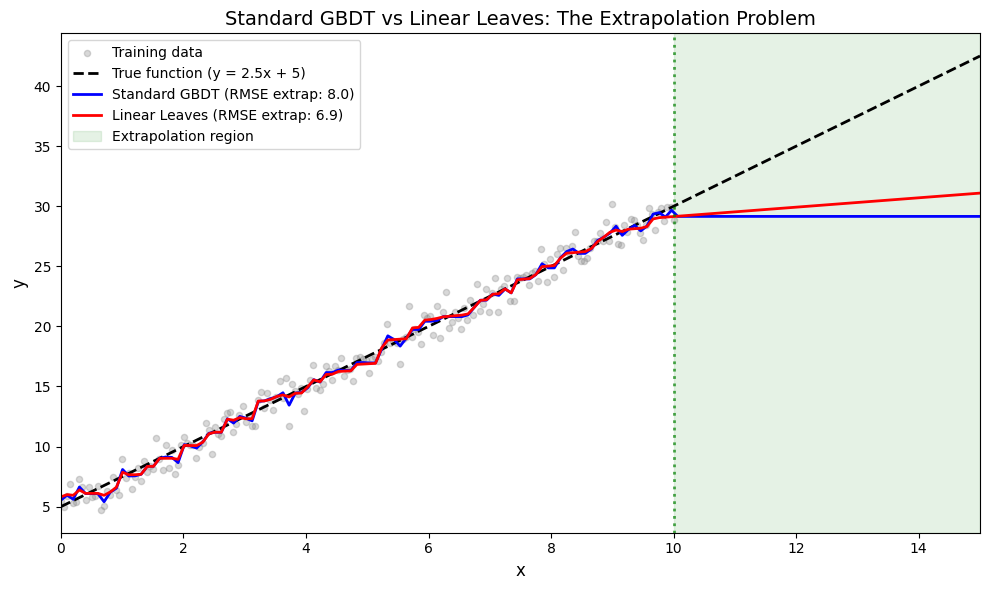

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

# Training data
ax.scatter(X_train, y_train, alpha=0.3, s=20, label='Training data', color='gray')

# True function
ax.plot(X_test, y_true, 'k--', lw=2, label='True function (y = 2.5x + 5)')

# Predictions
ax.plot(X_test, y_pred_standard, 'b-', lw=2, label=f'Standard GBDT (RMSE extrap: {rmse_extrap_standard:.1f})')
ax.plot(X_test, y_pred_linear, 'r-', lw=2, label=f'Linear Leaves (RMSE extrap: {rmse_extrap_linear:.1f})')

# Mark extrapolation region
ax.axvline(x=10, color='green', linestyle=':', lw=2, alpha=0.7)
ax.axvspan(10, 15, alpha=0.1, color='green', label='Extrapolation region')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Standard GBDT vs Linear Leaves: The Extrapolation Problem', fontsize=14)
ax.legend(loc='upper left')
ax.set_xlim(0, 15)

plt.tight_layout()
plt.show()

## Performance Comparison Summary

In [6]:
# Full test set metrics
rmse_full_standard = np.sqrt(mean_squared_error(y_true, y_pred_standard))
rmse_full_linear = np.sqrt(mean_squared_error(y_true, y_pred_linear))
r2_standard = r2_score(y_true, y_pred_standard)
r2_linear = r2_score(y_true, y_pred_linear)

# Interpolation region metrics (x <= 10)
interp_mask = X_test[:, 0] <= 10
rmse_interp_standard = np.sqrt(mean_squared_error(y_true[interp_mask], y_pred_standard[interp_mask]))
rmse_interp_linear = np.sqrt(mean_squared_error(y_true[interp_mask], y_pred_linear[interp_mask]))

print("="*60)
print("Performance Comparison: Standard GBDT vs Linear Leaves")
print("="*60)
print(f"{'Region':<25} {'Standard GBDT':<15} {'Linear Leaves':<15}")
print("-"*60)
print(f"{'Interpolation (x ≤ 10)':<25} {rmse_interp_standard:<15.3f} {rmse_interp_linear:<15.3f}")
print(f"{'Extrapolation (x > 10)':<25} {rmse_extrap_standard:<15.3f} {rmse_extrap_linear:<15.3f}")
print(f"{'Full test set':<25} {rmse_full_standard:<15.3f} {rmse_full_linear:<15.3f}")
print(f"{'R² (full set)':<25} {r2_standard:<15.3f} {r2_linear:<15.3f}")
print("="*60)
print("\n📊 Key insight: Both methods work similarly in the training range,")
print("   but linear leaves dramatically outperform on extrapolation!")

Performance Comparison: Standard GBDT vs Linear Leaves
Region                    Standard GBDT   Linear Leaves  
------------------------------------------------------------
Interpolation (x ≤ 10)    0.444           0.395          
Extrapolation (x > 10)    8.046           6.919          
Full test set             4.659           4.008          
R² (full set)             0.817           0.865          

📊 Key insight: Both methods work similarly in the training range,
   but linear leaves dramatically outperform on extrapolation!


## Tuning Linear Leaves Parameters

Key parameters for linear leaves:
- `linear_l2`: L2 regularization (higher = more conservative extrapolation)
- `max_depth`: Often shallower trees work well with linear leaves
- `n_estimators`: Fewer trees needed compared to standard GBDT

In [9]:
# Test different L2 regularization values on extrapolation
l2_values = [0.0, 0.01, 0.1, 1.0, 10.0]

print(f"{'L2 Regularization':<20} {'RMSE (interpolation)':<25} {'RMSE (extrapolation)':<25}")
print("-"*70)

for l2 in l2_values:
    config = boosters.GBDTConfig(
        n_estimators=50, max_depth=4, learning_rate=0.1,
        linear_leaves=True, linear_l2=l2
    )
    model = boosters.GBDTModel.train(train_data, config=config)
    pred = model.predict(test_data).flatten()
    
    rmse_in = np.sqrt(mean_squared_error(y_true[interp_mask], pred[interp_mask]))
    rmse_out = np.sqrt(mean_squared_error(y_true[extrap_mask], pred[extrap_mask]))
    
    print(f"{l2:<20} {rmse_in:<25.3f} {rmse_out:<25.3f}")

print("\n💡 Note: Higher L2 regularization makes extrapolation more conservative.")
print("   Find the right balance for your problem!")

L2 Regularization    RMSE (interpolation)      RMSE (extrapolation)     
----------------------------------------------------------------------
0.0                  0.395                     6.919                    
0.01                 0.395                     6.919                    
0.1                  0.395                     6.919                    
1.0                  0.395                     6.920                    
10.0                 0.392                     6.933                    

💡 Note: Higher L2 regularization makes extrapolation more conservative.
   Find the right balance for your problem!


## When NOT to Use Linear Leaves

Linear leaves shine when data has local linear trends. For purely non-linear patterns (sin, XOR, step functions), standard GBDT may work better:

In [10]:
# Generate purely non-linear data (step function - no linear trends)
np.random.seed(123)
X_step = np.linspace(0, 10, 500).reshape(-1, 1).astype(np.float32)
y_step = (np.sign(np.sin(X_step[:, 0] * 2)) * 5 + np.random.randn(500) * 0.5).astype(np.float32)

# Split
X_step_train, X_step_test, y_step_train, y_step_test = train_test_split(
    X_step, y_step, test_size=0.3, random_state=42
)

step_train = boosters.Dataset(X_step_train, y_step_train)
step_test = boosters.Dataset(X_step_test)

# Train both
model_step_std = boosters.GBDTModel.train(step_train, config=boosters.GBDTConfig(
    n_estimators=100, max_depth=6, linear_leaves=False
))
model_step_lin = boosters.GBDTModel.train(step_train, config=boosters.GBDTConfig(
    n_estimators=50, max_depth=4, linear_leaves=True, linear_l2=0.01
))

pred_step_std = model_step_std.predict(step_test).flatten()
pred_step_lin = model_step_lin.predict(step_test).flatten()

print("Performance on STEP FUNCTION data (no linear trends):")
print(f"  Standard GBDT R²: {r2_score(y_step_test, pred_step_std):.4f}")
print(f"  Linear Leaves R²: {r2_score(y_step_test, pred_step_lin):.4f}")
print("\n→ For step functions/non-linear data, standard GBDT often wins!")

Performance on STEP FUNCTION data (no linear trends):
  Standard GBDT R²: 0.9481
  Linear Leaves R²: 0.9500

→ For step functions/non-linear data, standard GBDT often wins!


## Summary

**Linear leaves are powerful when you need to extrapolate beyond training data:**

✅ **Use linear leaves when:**
- Data has local linear trends
- You need to predict outside the training range (e.g., future time periods)
- Feature relationships are approximately linear within regions

❌ **Stick with standard GBDT when:**
- Data is purely non-linear (step functions, complex interactions)
- All predictions will be within the training data range
- You're unsure - standard GBDT is a safer default

**Key parameters for linear leaves:**
- `linear_l2`: Higher values = more conservative extrapolation
- `max_depth`: Try shallower trees (3-4) than standard GBDT
- `n_estimators`: Usually need fewer trees than standard GBDT